# **Group 5: Examination of Health Data Breaches Study**

Ivory Chorng, Noel Thomas




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
def read_file(path: str) -> pd.DataFrame:
    """
    This function helps us read the file in. The path can be specified in the function call in the main() function and
    this function returns the dataframe.
    :param path: The path of the file in the user's system.
    :return: The dataframe.
    """

    #absolute_path = os.path.dirname(__file__)
    #relative_path = path
    #final_path = os.path.join(absolute_path, relative_path)
    final_path = path

    d_parser = lambda x: pd.to_datetime(x, errors='coerce')
    df = pd.read_csv(final_path, encoding='latin1', dtype={'Type of Breach': 'string'},
                      parse_dates=['Breach Submission Date'], date_parser=d_parser)

    return df

In [ ]:
file_path = 'breach_report.csv'

df1 = read_file(file_path)

In [ ]:
def adjust_time_limits(df: pd.DataFrame, end: str = '2013-09-22', start: str = '2009-01-01') -> pd.DataFrame:
    """
    This function helps us extract the breaches between any two dates we desire.

    :param df: The entire dataframe.
    :param end: The desired end date.
    :param start: The desired start date.
    :return: The dataframe with records between the desired date limits.

    >>> df = pd.DataFrame([[1,'2008-12-31'], [2,'2010-07-15'], [3,'2012-12-24']], columns=["A", "Breach Submission Date"])
    >>> df = adjust_time_limits(df, '2012-12-31')
    >>> df.head()
       A Breach Submission Date
    1  2             2010-07-15
    2  3             2012-12-24

    >>> df = pd.DataFrame([[1,'2009-01-02'], [2,'2010-07-15'], [3,'2012-12-24']], columns=["A", "Breach Submission Date"])
    >>> df = adjust_time_limits(df, '2012-12-31', '2009-01-01')
    >>> df.head()
       A Breach Submission Date
    0  1             2009-01-02
    1  2             2010-07-15
    2  3             2012-12-24

    >>> df = pd.DataFrame([[1,'2009-01-02'], [2,'2010-07-15'], [3,'2012-12-24']], columns=["A", "Breach Submission Date"])
    >>> df = adjust_time_limits(df, '2009-01-01', '2012-12-31')
    >>> df.head()
    Empty DataFrame
    Columns: [A, Breach Submission Date]
    Index: []

    """

    df = df.loc[(df['Breach Submission Date'] >= start) & (df['Breach Submission Date'] <= end)]

    return df

In [ ]:
def cleanup(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function 'cleans' the dataframe. First, it removes the null values, and then 'fixes' a few columns by calling
    the change_to_binary() function and fix_columns() function. The reason why this is a separate function is that
    the functions that perform the analysis and create the visualizations are independent of each other. A user could
    want to see the seasonal trends in a desired date range and look at the analysis of a different date range
    entirely. Hence, the original dataframe is passed into those three functions (analyze_column(), plot_seasonal(),
    and check_trends()) and each of those functions call the cleanup() function individually.

    :param df: The original, unprocessed dataframe.
    :return: The cleaned, processed dataframe.

    >>> df = pd.DataFrame([['CA', 'Health Plan', 'Yes', '13', 'Loss', 'Email', 'Lost via Email'], ['NY', 'Health Plan', 'No', '7', 'Theft', 'Laptop', 'Laptop stolen']], columns=['State', 'Covered Entity Type', 'Business Associate Present', 'Individuals Affected', 'Type of Breach', 'Location of Breached Information', 'Web Description'])
    >>> df = cleanup(df)
    >>> df.head() # doctest: +ELLIPSIS
      State Covered Entity Type  ...  Location of Breach Covered Entities Involved
    0    CA         Health Plan  ...              E-mail                         1
    1    NY         Health Plan  ...             Laptops                         1
    <BLANKLINE>
    [2 rows x 8 columns]

    >>> df = pd.DataFrame([['CA', 'Health Plan', 'Yes', '13', 'Loss', 'Email', 'Lost via Email'], ['NY', 'Health Plan', 'No', '7', 'Theft', 'Laptop', None]], columns=['State', 'Covered Entity Type', 'Business Associate Present', 'Individuals Affected', 'Type of Breach', 'Location of Breached Information', 'Web Description'])
    >>> df = cleanup(df)
    >>> df.head() # doctest: +ELLIPSIS
      State Covered Entity Type  ...  Location of Breach Covered Entities Involved
    0    CA         Health Plan  ...              E-mail                         1
    <BLANKLINE>
    [1 rows x 8 columns]


    """
    # print("Number of null values in each column: \n{}\n".format(df.isna().sum(axis=0)))
    # print("Percentage of null values in each column (before cleanup): \n{}".format(
    #    round(df.isna().sum() * 100 / len(df), 2)))
    df = df.dropna(subset=['State', 'Covered Entity Type', 'Individuals Affected', 'Type of Breach',
                           'Location of Breached Information', 'Web Description'])

    df = fix_columns(df, 'Type of Breach')

    df = fix_columns(df, 'Location of Breached Information')

    df['Business Associate Present'] = df.apply(
        lambda dataset: change_to_binary(dataset, 'Business Associate Present'),
        axis=1)

    df['Covered Entities Involved'] = df.apply(lambda dataset: change_to_binary(dataset, 'Covered Entity Type'),
                                               axis=1)

    return df

In [ ]:
def change_to_binary(df: pd.DataFrame, column_name: str) -> int:
    """
    The purpose of this function is to change the values of certain columns from string to binary, for the purpose of
    understanding and analyzing the aggregations. 'Covered Entity Type' and 'Business Associate Present' both are
    string values, and need to be converted to integer values. To do this, a 1 is returned if a value exists in the
    'Covered Entity Type' column and a 0 if it doesn't have a value. If the value is a 'Yes' in the
    'Business Associate Present' column, a 1 is returned, and a 0 is returned if the value is 'No'.

    :param df: The dataframe containing the columns that need to be converted.
    :param column_name: The name of the column that needs to be converted.
    :return: The dataframe with the new/updated column.

    >>> df = pd.DataFrame([[1,'Healthcare Provider'], [2,'Health Plan'], [3, ]], columns=["A", "Covered Entity Type"])
    >>> df['Covered Entities Involved'] = df.apply(lambda dataset: change_to_binary(dataset, 'Covered Entity Type'), axis=1)
    >>> df.head()
       A  Covered Entity Type  Covered Entities Involved
    0  1  Healthcare Provider                          1
    1  2          Health Plan                          1
    2  3                 None                          0

    >>> df = pd.DataFrame([[1,'Yes'], [2,'No'], [3, 'Yes']], columns=["A", "Business Associate Present"])
    >>> df['Business Associate Present'] = df.apply(lambda dataset: change_to_binary(dataset, 'Business Associate Present'), axis=1)
    >>> df.head()
       A  Business Associate Present
    0  1                           1
    1  2                           0
    2  3                           1
    """
    if column_name == 'Covered Entity Type':
        if df['Covered Entity Type']:
            return 1
        else:
            return 0

    if column_name == 'Business Associate Present':
        if df['Business Associate Present'] == 'Yes':
            return 1
        elif df['Business Associate Present'] == 'No':
            return 0

In [ ]:
def fix_columns(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    The function performs something like a 'cleanup' of the values in certain columns. For example, the column
    'Type of Breach' has overlapping values. The six unique values it is supposed to have are: Hacking/IT Incident,
    Improper Disposal, Loss, Unauthorized Access/Disclosure, Theft and Other/Unkown. However, the values it initially
    contains include values like: "Hacking/IT Incident, Other, Unauthorized Access/Disclosure" and
    "Improper Disposal, Loss, Theft", where more than one unique values overlap. This issue does not help us in
    performing our analysis. The author of the study mentions that they use Microsoft Excel and its pivot table feature
    to fix this issue. We decided to use this function to do this.

    This function accepts the dataframe and the column name that needs to be 'cleaned' and creates a new column that
    assigns each date breach to a unique value from the old column (with the overlapping values).

    :param df: This is the dataframe with the column that needs to be cleaned.
    :param column_name: This is the name of the column that needs to be cleaned.
    :return: A dataframe with a new column containing no overlapping and only unique values.

    >>> df = pd.DataFrame([[1,'Hacking/IT Incident, Theft'], [2,'Improper Disposal, Loss, Theft']], columns=["A", "Type of Breach"]) 
    >>> df = fix_columns(df,'Type of Breach')
    >>> df.head()
       A       Type of Breach
    0  1  Hacking/IT Incident
    1  2    Improper Disposal

    >>> df = pd.DataFrame([[1,'Laptop, Network Server'], [2,'Desktop Computer, Laptop']], columns=["A", "Location of Breached Information"])
    >>> df = fix_columns(df,'Location of Breached Information')
    >>> df.head()
       A Location of Breach
    0  1            Laptops
    1  2  Desktop Computers

    >>> df = pd.DataFrame([[1,'Theft, Loss'], [2,'Loss, Other, Theft']], columns=["A", "Type of Breach"])
    >>> df = fix_columns(df,'Unknown column')
    The column name is not one of the columns in the dataframe. Returning the unchanged dataframe.
    >>> df.head()
       A      Type of Breach
    0  1         Theft, Loss
    1  2  Loss, Other, Theft
    """

    if column_name == 'Type of Breach':
        for x in df[column_name]:
            if 'Hacking/IT Incident' in x:
                df.loc[df[column_name] == x, 'Breach Type'] = 'Hacking/IT Incident'
                continue
            if 'Improper Disposal' in x:
                df.loc[df[column_name] == x, 'Breach Type'] = 'Improper Disposal'
                continue
            if 'Loss' in x:
                df.loc[df[column_name] == x, 'Breach Type'] = 'Loss'
                continue
            if 'Unauthorized Access/Disclosure' in x:
                df.loc[df[column_name] == x, 'Breach Type'] = 'Unauthorized Access/Disclosure'
                continue
            if 'Theft' in x:
                df.loc[df[column_name] == x, 'Breach Type'] = 'Theft'
                continue
            if 'Unknown' in x or 'Other' in x:
                df.loc[df[column_name] == x, 'Breach Type'] = 'Other/Unknown'
                continue
        df.drop([column_name], axis=1, inplace=True)
        df = df.rename(columns={'Breach Type': column_name})
        return df

    if column_name == 'Location of Breached Information':
        for x in df[column_name]:
            if 'Desktop Computer' in x:
                df.loc[df[column_name] == x, 'Location'] = 'Desktop Computers'
                continue
            if 'Electronic Medical Record' in x:
                df.loc[df[column_name] == x, 'Location'] = 'Electronic health records'
                continue
            if 'Email' in x:
                df.loc[df[column_name] == x, 'Location'] = 'E-mail'
                continue
            if 'Laptop' in x:
                df.loc[df[column_name] == x, 'Location'] = 'Laptops'
                continue
            if 'Network Server' in x:
                df.loc[df[column_name] == x, 'Location'] = 'Network Servers'
                continue
            if 'Other' in x:
                df.loc[df[column_name] == x, 'Location'] = 'Others'
            if 'Paper' in x:
                df.loc[df[column_name] == x, 'Location'] = 'Paper'
                continue
        df.drop([column_name], axis=1, inplace=True)
        df = df.rename(columns={'Location': 'Location of Breach'})
        return df

    if column_name not in df.columns:
        print("The column name is not one of the columns in the dataframe. Returning the unchanged dataframe.")
        return df


In [ ]:
def analyze_column(df: pd.DataFrame, column_name: str, end: str = '2013-09-22', start: str = '2009-01-01') -> None:
    """

    This function performs the group_by() on the desired column and plots the aggregated values of individuals affected,
    'business associate present' and 'covered entities involved'.

    :param df: The dataframe containing the columns to be aggregated.
    :param column_name: The column by which the dataframe will be aggregated by.
    :param end: The end date of the desired timeframe.
    :param start: The start date of the desired timeframe.
    :return: Prints all the required information inside the function. No return value.

    >>> df = pd.DataFrame([['CA', 'Health Plan', 'Yes', 13, 'Loss', 'Email', 'Lost via Email','2010-15-02'], ['NY', 'Health Plan', 'No', 7, 'Theft', 'Laptop', 'Laptop stolen','2009-01-02']], columns=['State', 'Covered Entity Type', 'Business Associate Present', 'Individuals Affected', 'Type of Breach', 'Location of Breached Information', 'Web Description', "Breach Submission Date"])
    >>> analyze_column(df,'Type of Breach') # doctest: +ELLIPSIS
    Aggregated values when grouped by Type of Breach:
                    Business Associate Present  ...  Covered Entities Involved
    Type of Breach                              ...
    Loss                                     1  ...                          1
    Theft                                    0  ...                          1
    <BLANKLINE>
    [2 rows x 3 columns]
                    Business Associate Present  ...  Covered Entities Involved
    Type of Breach                              ...
    Loss                                 100.0  ...                       50.0
    Theft                                  0.0  ...                       50.0
    <BLANKLINE>
    [2 rows x 3 columns]

    >>> df = pd.DataFrame([['CA', 'Health Plan', 'Yes', 5, 'Loss', 'Email', 'Lost via Email','2010-15-02'], ['NY', 'Health Plan', 'No', 9, 'Theft', 'Laptop', 'Laptop stolen','2009-01-02'], ['TX', 'Health Plan', 'No', 9, 'Theft', 'Laptop', None, '2009-01-02']], columns=['State', 'Covered Entity Type', 'Business Associate Present', 'Individuals Affected', 'Type of Breach', 'Location of Breached Information', 'Web Description', "Breach Submission Date"])
    >>> analyze_column(df,'Type of Breach') # doctest: +ELLIPSIS
    Aggregated values when grouped by Type of Breach:
                    Business Associate Present  ...  Covered Entities Involved
    Type of Breach                              ...
    Loss                                     1  ...                          1
    Theft                                    0  ...                          1
    <BLANKLINE>
    [2 rows x 3 columns]
                    Business Associate Present  ...  Covered Entities Involved
    Type of Breach                              ...
    Loss                                 100.0  ...                       50.0
    Theft                                  0.0  ...                       50.0
    <BLANKLINE>
    [2 rows x 3 columns]

    >>> df = pd.DataFrame([['NY', 'Health Plan', 'No', 9, 'Theft', 'Laptop', 'Laptop stolen','2009-01-02'], ['NY', 'Health Plan', 'No', 17, 'Theft', 'Laptop', 'Laptop stolen','2009-01-02']], columns=['State', 'Covered Entity Type', 'Business Associate Present', 'Individuals Affected', 'Type of Breach', 'Location of Breached Information', 'Web Description', "Breach Submission Date"])
    >>> analyze_column(df,'Type of Breach') # doctest: +ELLIPSIS
    Aggregated values when grouped by Type of Breach:
                    Business Associate Present  ...  Covered Entities Involved
    Type of Breach                              ...
    Theft                                    0  ...                          2
    <BLANKLINE>
    [1 rows x 3 columns]
                    Business Associate Present  ...  Covered Entities Involved
    Type of Breach                              ...
    Theft                                  NaN  ...                      100.0
    <BLANKLINE>
    [1 rows x 3 columns]

    """

    df = adjust_time_limits(df, end, start)

    df = cleanup(df)

    #pd.set_option('display.max_columns', 3)
    print("Aggregated values when grouped by {}:".format(column_name))
    agg = df.groupby([column_name]).sum()
    print(agg)

    percentage_values = round(agg.apply(lambda x: 100 * x / float(x.sum())), 2)
    print(percentage_values)

    percentage_values.plot(kind='bar', title=column_name)
    plt.show()


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

Aggregated values when grouped by Type of Breach:
                                Individuals Affected  \
Type of Breach                                         
Hacking/IT Incident                        1343032.0   
Improper Disposal                           644108.0   
Loss                                       7101794.0   
Other/Unknown                              2781311.0   
Theft                                     13833767.0   
Unauthorized Access/Disclosure              927079.0   

                                Business Associate Present  \
Type of Breach                                               
Hacking/IT Incident                                     13   
Improper Disposal                                        9   
Loss                                                    15   
Other/Unknown                                           17   
Theft                                                   78   
Unauthorized Access/Disclosure                          34   

    

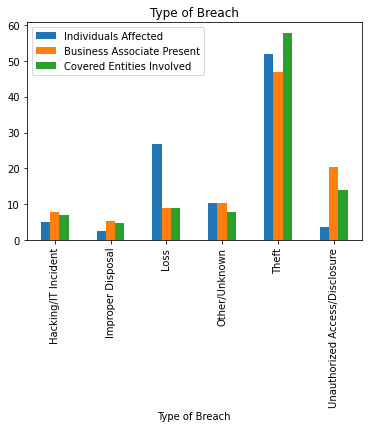

In [ ]:
analyze_column(df1, 'Type of Breach', '2013-09-22')

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

Aggregated values when grouped by Location of Breach:
                           Individuals Affected  Business Associate Present  \
Location of Breach                                                            
Desktop Computers                     6599852.0                          12   
E-mail                                 323318.0                           2   
Electronic health records             2693049.0                           3   
Laptops                               2685141.0                          28   
Network Servers                       1878306.0                          24   
Others                               11320147.0                          51   
Paper                                 1131278.0                          46   

                           Covered Entities Involved  
Location of Breach                                    
Desktop Computers                                115  
E-mail                                            26  
Electronic hea

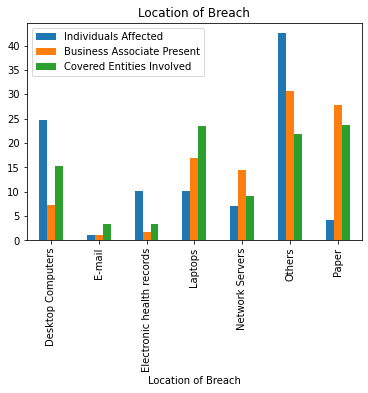

In [ ]:
analyze_column(df1, 'Location of Breach', '2013-09-22')

In [ ]:
def plot_seasonal(df: pd.DataFrame, end: str = '2013-09-22', start: str = '2009-01-01') -> None:
    """
    This function plots the yearly aggregated values of the effects of data breaches, superimposed on each other to
    look at any seasonal trends. Additionally, it calls the adjust_time_limits() function to set the timeframe to a
    desired value.
    :param df: The dataframe containing the values to be aggregated and visualized.
    :param end: The end date of the desired timeframe.
    :param start: The start date of the desired timeframe.
    :return: The function plots the aggregated values. No return value.

    """

    df = adjust_time_limits(df, end, start)

    df = cleanup(df)

    df['Year'] = pd.DatetimeIndex(df['Breach Submission Date']).year
    df['Month'] = pd.DatetimeIndex(df['Breach Submission Date']).month

    flag = 0
    date = df.groupby(['Year', 'Month']).sum()

    for i, j in date.groupby(level=0):

        if flag == 0:
            ax = date.loc[i].plot(y='Individuals Affected', label=i)
            flag = 1
            continue
        date.loc[i].plot(y='Individuals Affected', ax=ax, figsize=(16, 10), use_index=False, grid=True, label=i,
                         legend=True)
        ax.set(xlabel="Month", ylabel="Number of Individuals affected",
               title="Number of Individuals affected every year")
    plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

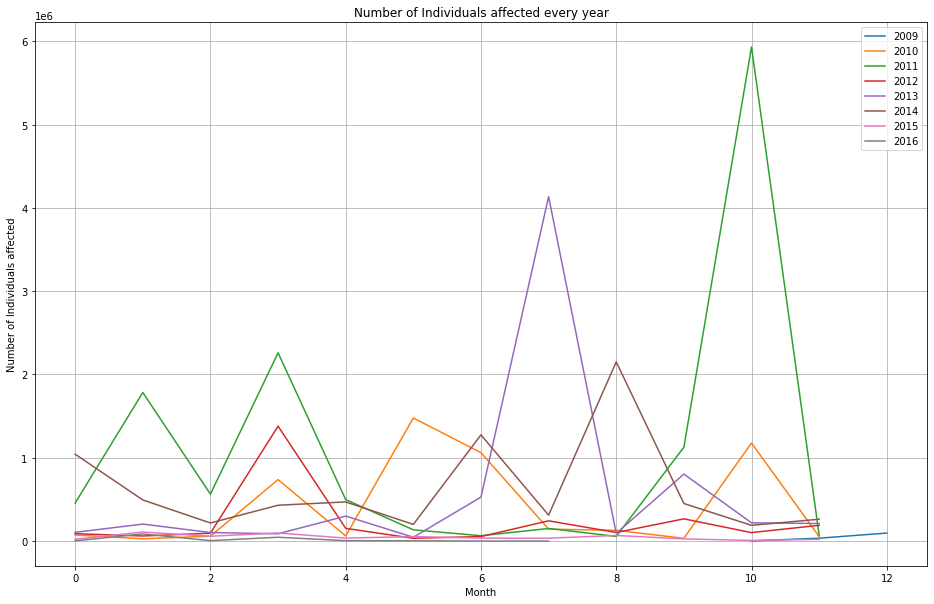

In [ ]:
plot_seasonal(df1, '2022-09-22')

In [ ]:
def check_trends(df: pd.DataFrame, end: str = '2013-09-22', start: str = '2009-01-01') -> None:
    """
    This function counts the number of data breaches between the specified timeframe and plots them, essentially
    showing us a trend of data breaches in the United States during that period of time.

    :param df: The dataframe containing the values to be aggregated and visualized.
    :param end: The end date of the desired timeframe.
    :param start: The start date of the desired timeframe.
    :return: The function plots the aggregated values. No return value.
    """
    df = adjust_time_limits(df, end, start)

    df = cleanup(df)

    df['Year'] = pd.DatetimeIndex(df['Breach Submission Date']).year
    df['Month'] = pd.DatetimeIndex(df['Breach Submission Date']).month

    date = df.groupby(['Year', 'Month']).count()

    date.plot(y='Individuals Affected', figsize=(16, 10))

    plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

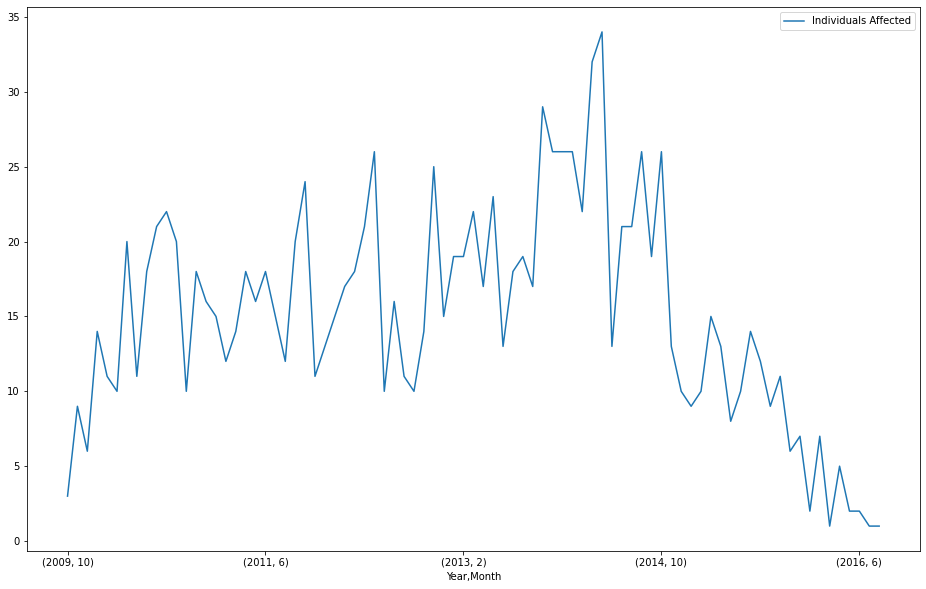

In [ ]:
check_trends(df1, '2022-09-22')

In [ ]:
def analyze_multi_column(df: pd.DataFrame, col1: str, col2: str, end: str = '2013-09-22', start: str = '2009-01-01') -> None:
    """
    This function helps us analyze data breaches by more than one category. We use it to look at the type of breaches
    in each state, or the location of breaches in each state. From this, we can aggregate these values to look at the
    highest contributors to data breaches in all the US states. To do this, we first group by the state and the
    second category (type or location of breach), which results in a multi index. Then we create a new column of the
    second level of the multi index, which is essentially the type or location value. And then we select the maximum
    value of the first level of the multi index (the state). And finally we can group by the new column we created
    and plot the occurrences of data breaches by their cause (either type or location).

    :param df: The dataframe containing the columns to be aggregated and analyzed.
    :param col1: The first column to aggregate by.
    :param col2: The second column to aggregate by.
    :param end: The end date of the desired timeframe.
    :param start: The start date of the desired timeframe.
    :return: Prints and plots all the required information inside the function. No return value.
    """
    df = adjust_time_limits(df, end, start)
    df = cleanup(df)

    df2 = df.groupby([col1, col2]).sum()

    df2['Cause'] = df2.index.get_level_values(1)

    df3 = df2.groupby(level=0).apply(max)
    print(df3)
    df3.groupby(['Cause']).count().plot(kind = 'bar', y='Individuals Affected', grid=True, legend=False, xlabel= col2,
              ylabel="Number of data breaches", title="Highest contributors of data breaches in all states", figsize=(10,10), rot=0)
    plt.show()



/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

       Individuals Affected  Business Associate Present  \
State                                                     
AK                   2743.0                           1   
AL                 967678.0                           3   
AR                  19397.0                           1   
AZ                  90505.0                           2   
CA                1087087.0                          11   
CO                 111806.0                           2   
CT                 113636.0                           3   
DC                  20416.0                           2   
DE                   1883.0                           0   
FL                1275984.0                           2   
GA                 409449.0                           3   
HI                   2809.0                           0   
IA                  26557.0                           0   
ID                  14962.0                           2   
IL                4044670.0                           6 

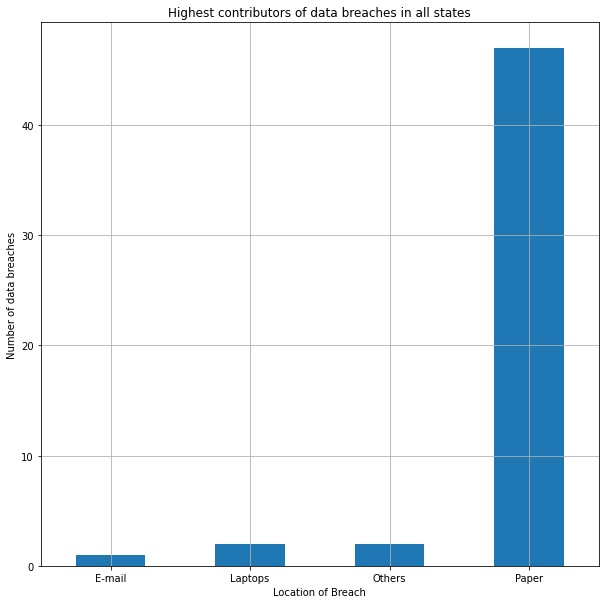

In [ ]:
analyze_multi_column(df1, 'State', 'Location of Breach', '2022-09-22')

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

       Individuals Affected  Business Associate Present  \
State                                                     
AK                   4299.0                           2   
AL                 976446.0                           2   
AR                  22513.0                           1   
AZ                  73023.0                           2   
CA                2091912.0                          10   
CO                 115527.0                           2   
CT                 197079.0                           4   
DC                  18000.0                           1   
DE                   1883.0                           0   
FL                1601546.0                           2   
GA                 327700.0                           3   
HI                   2809.0                           0   
IA                  26557.0                           0   
ID                   9462.0                           1   
IL                4320337.0                           8 

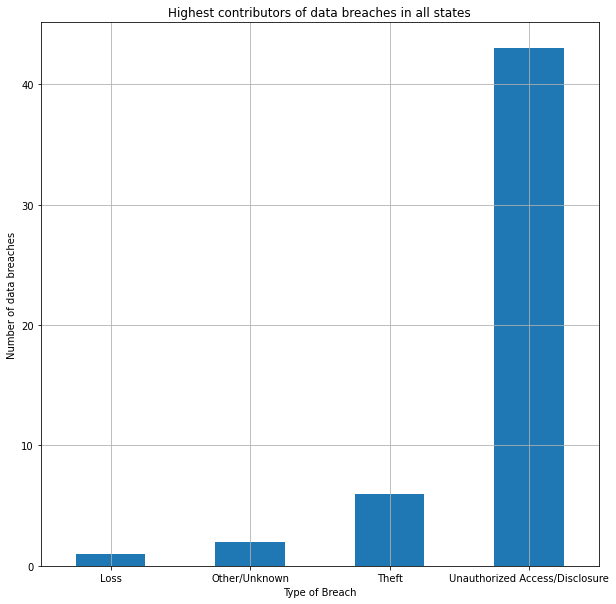

In [ ]:
analyze_multi_column(df1, 'State', 'Type of Breach', '2022-09-22')